In [8]:
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample


In [9]:
# Cargar archivo de Excel con la hoja principal
df = pd.read_excel("Datos_proyecto.xlsx", sheet_name="Sheet1")

# Renombrar columnas para que tengan nombres claros
df = df.rename(columns={"textos": "texto", "labels": "ods"})

df.head()

,texto,ods
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


# ENTENDIMIENTO (perfilamiento)

## Vista rápida

In [14]:
def ver_forma(df):
    return df.shape

def ver_columnas(df):
    return df.columns.tolist()

def ver_tipos(df):
    return df.dtypes

def ver_nulos(df):
    return df.isna().sum().sort_values(ascending=False)

def ver_muestra(df, n=5, seed=0):
    return df.sample(min(n, len(df)), random_state=seed)

print("Forma del dataset:", ver_forma(df))
print("Columnas:", ver_columnas(df))
print("Tipos de datos:\n", ver_tipos(df))
print("Nulos:\n", ver_nulos(df))
print("Ejemplo de filas:")
display(ver_muestra(df, n=5))


Forma del dataset: (2424, 4)
Columnas: ['texto', 'ods', 'len_chars', 'len_words']
Tipos de datos:
 texto        object
ods           int64
len_chars     int64
len_words     int64
dtype: object
Nulos:
 texto        0
ods          0
len_chars    0
len_words    0
dtype: int64
Ejemplo de filas:


,texto,ods,len_chars,len_words
2052,Disponibilidad de los resultados de las evalua...,4,989,149
743,El capítulo también examina la coherencia y co...,4,1198,179
1968,Establecer una expectativa de mejora continua ...,4,809,125
1388,No hay centros especiales para alumnos con dif...,4,954,138
1983,Se desarrolló a finales de la década de 1960 e...,4,690,109


Resultado: Se ve el tamaño (filas, columnas), lista de columnas, tipos de datos, nulos por columna y 5 ejemplos de opiniones.

## Longitudes de texto

In [11]:
def agregar_longitudes(df, col_texto="texto"):
    out = df.copy()
    out["len_chars"] = out[col_texto].astype(str).str.len()
    out["len_words"] = out[col_texto].astype(str).str.split().str.len()
    return out

def resumen_longitudes(df):
    desc = df[["len_chars","len_words"]].describe()
    return desc

df = agregar_longitudes(df, "texto")
print("Resumen de longitudes:")
display(resumen_longitudes(df))


Resumen de longitudes:


,len_chars,len_words
count,2424.000000,2424.000000
mean,683.223185,107.924092
std,223.563695,35.575349
min,303.000000,41.000000
25%,513.000000,81.000000
50%,647.000000,102.000000
75%,809.250000,129.000000
max,1492.000000,260.000000


Resultado: una tabla con estadísticas de longitud de caracteres y palabras (mínimo, máximo, promedio, etc.).

## Distribuciones simples

Conteo de clases:
ods
4    1025
3     894
1     505
Name: count, dtype: int64


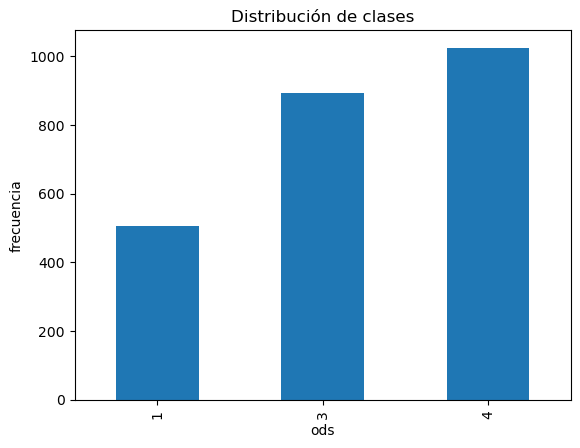

In [12]:
def conteo_categoria(df, col, top=10):
    return df[col].value_counts().head(top)

def graficar_distribucion_clase(df, col_label="ods"):
    dist = df[col_label].value_counts().sort_index()
    ax = dist.plot(kind="bar")
    ax.set_title("Distribución de clases")
    ax.set_xlabel(col_label)
    ax.set_ylabel("frecuencia")
    plt.show()

print("Conteo de clases:")
print(df["ods"].value_counts())
graficar_distribucion_clase(df, "ods")

Resultado: conteo de cuántos ejemplos hay en cada ODS y un gráfico de barras.

## Calidad básica

In [13]:
def contar_duplicados(df, cols=None):
    cols = df.columns.tolist() if cols is None else cols
    return df.duplicated(subset=cols).sum()

def contar_textos_vacios(df, col_texto="texto"):
    return (df[col_texto].astype(str).str.strip()=="").sum()

def contar_textos_muy_cortos(df, min_palabras=2, col_texto="texto"):
    return (df[col_texto].astype(str).str.split().str.len()<=min_palabras).sum()

print("Duplicados:", contar_duplicados(df, ["texto"]))
print("Textos vacíos:", contar_textos_vacios(df, "texto"))
print("Textos muy cortos:", contar_textos_muy_cortos(df, min_palabras=2, col_texto="texto"))



Duplicados: 0
Textos vacíos: 0
Textos muy cortos: 0


Resultado: número de duplicados, vacíos y textos demasiado cortos.

# LIMPIEZA / PREPARACIÓN

In [16]:
STOP_ES = set("""
de la que el en y a los las del se por un con para una su al lo como mas o sus
entre tambien fue e ya si pero sobre este esta estos estas hay no si es son ser
""".split())


## Funciones de limpieza

In [17]:
def a_minusculas(t):         
    return str(t).lower()
def quitar_urls(t):          
    return re.sub(r"http\S+|www\.\S+", " ", str(t))
def quitar_emails(t):        
    return re.sub(r"\S+@\S+\.\S+", " ", str(t))
def quitar_numeros(t):       
    return re.sub(r"\d+", " ", str(t))
def quitar_puntuacion(t):
    tabla = str.maketrans("", "", string.punctuation + "“”»«¿?¡!…")
    return str(t).translate(tabla)
def quitar_acentos(t):       
    return unidecode(str(t))
def colapsar_espacios(t):    
    return re.sub(r"\s+", " ", str(t)).strip()
def quitar_stopwords(t, stop=STOP_ES):
    toks = [w for w in str(t).split() if w not in stop]
    return " ".join(toks)


Resultados: cada función hace un paso de limpieza (minúsculas, quitar URLs, emails, números, puntuación, tildes, espacios repetidos y stopwords).

## Función de limpieza completa + aplicación

In [19]:
def limpiar_texto(t):
    t = a_minusculas(t)
    t = quitar_urls(t)
    t = quitar_emails(t)
    t = quitar_numeros(t)
    t = quitar_puntuacion(t)
    t = quitar_acentos(t)
    t = colapsar_espacios(t)
    t = quitar_stopwords(t)
    return t

def aplicar_limpieza(df, col_origen="texto", col_destino="texto_clean"):
    out = df.copy()
    out[col_destino] = out[col_origen].apply(limpiar_texto)
    return out

df_clean = aplicar_limpieza(df, col_origen="texto", col_destino="texto_clean")
df_clean[["texto", "texto_clean"]].head(10)


,texto,texto_clean
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",aprendizaje educacion consideran sinonimos esc...
1,Para los niños más pequeños (bebés y niños peq...,ninos pequenos bebes ninos pequenos capacitaci...
2,"Además, la formación de especialistas en medic...",ademas formacion especialistas medicina genera...
3,En los países de la OCDE se tiende a pasar de ...,paises ocde tiende pasar cursos obligatorios o...
4,Este grupo se centró en las personas que padec...,grupo centro personas padecen trastornos menta...
5,Los datos a nivel del sistema que no se deriva...,datos nivel sistema derivan cuestionario estud...
6,La principal ventaja de las evaluaciones exter...,principal ventaja evaluaciones externas fiabil...
7,Los pacientes pueden elegir a cualquier médico...,pacientes pueden elegir cualquier medico cabec...
8,"De hecho, es probable que la designación de la...",hecho probable designacion universidad univers...
9,"De hecho, aunque Chile y Uruguay tienen índice...",hecho aunque chile uruguay tienen indices pobr...


Resultados: crea una nueva columna texto_clean con el texto normalizado. La última línea muestra los primeros 10 antes/después.

## Verificación después de limpiar

Resultado: verifica que la limpieza no dejó strings vacíos y cuántos textos quedaron demasiado cortos.

In [20]:
def contar_vacios(df, col="texto_clean"):
    return (df[col].astype(str).str.strip()=="").sum()

def contar_muy_cortos(df, col="texto_clean", min_palabras=2):
    return (df[col].astype(str).str.split().str.len()<=min_palabras).sum()

print("Textos vacíos después de limpiar:", contar_vacios(df_clean, "texto_clean"))
print("Textos muy cortos (<=2 palabras) después de limpiar:", contar_muy_cortos(df_clean, "texto_clean", 2))


Textos vacíos después de limpiar: 0
Textos muy cortos (<=2 palabras) después de limpiar: 0


## Comparar longitudes antes y después

In [21]:
def agregar_longitudes(df, col_texto="texto"):
    out = df.copy()
    out["len_chars"] = out[col_texto].astype(str).str.len()
    out["len_words"] = out[col_texto].astype(str).str.split().str.len()
    return out

antes  = agregar_longitudes(df,       "texto")[["len_chars","len_words"]].describe()
despues= agregar_longitudes(df_clean, "texto_clean")[["len_chars","len_words"]].describe()

print("ANTES (texto original):")
display(antes)
print("DESPUÉS (texto_clean):")
display(despues)


ANTES (texto original):


,len_chars,len_words
count,2424.000000,2424.000000
mean,683.223185,107.924092
std,223.563695,35.575349
min,303.000000,41.000000
25%,513.000000,81.000000
50%,647.000000,102.000000
75%,809.250000,129.000000
max,1492.000000,260.000000


DESPUÉS (texto_clean):


,len_chars,len_words
count,2424.000000,2424.000000
mean,499.747112,57.526403
std,166.885421,18.881654
min,206.000000,24.000000
25%,377.000000,43.000000
50%,470.000000,54.000000
75%,594.000000,68.000000
max,1134.000000,128.000000


Resultado: compara estadísticos de longitudes antes y después de limpiar.

## Partición en train/val/test

In [26]:
def partir_estratificado(df, col_texto="texto_clean", col_label="ods",
                         test_size=0.2, val_size=0.1, seed=42):
    train_df, test_df = train_test_split(
        df[[col_texto, col_label]], test_size=test_size,
        stratify=df[col_label], random_state=seed
    )
    val_rel = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_df, test_size=val_rel, stratify=train_df[col_label], random_state=seed
    )
    return (train_df.reset_index(drop=True),
            val_df.reset_index(drop=True),
            test_df.reset_index(drop=True))

train_df, val_df, test_df = partir_estratificado(df_clean, "texto_clean", "ods")
print(len(train_df), len(val_df), len(test_df))


1696 243 485


Resultado: separa el dataset limpio en entrenamiento, validación y prueba manteniendo la proporción de clases.

## Rebalanceo del set de entrenamiento

In [27]:
def balancear_undersampling(train_df, col_label="ods", seed=42):
    objetivo = train_df[col_label].value_counts().min()
    partes = []
    for k, sub in train_df.groupby(col_label):
        partes.append(resample(sub, replace=False, n_samples=objetivo, random_state=seed))
    out = pd.concat(partes).sample(frac=1, random_state=seed).reset_index(drop=True)
    return out

print("Antes (train):")
print(train_df["ods"].value_counts())
train_bal = balancear_undersampling(train_df, "ods")
print("\nDespués (train balanceado):")
print(train_bal["ods"].value_counts())


Antes (train):
ods
4    717
3    626
1    353
Name: count, dtype: int64

Después (train balanceado):
ods
3    353
1    353
4    353
Name: count, dtype: int64


Resultado: iguala el tamaño de cada clase en train_df para evitar sesgo.

## Vectorización TF-IDF

In [28]:
def crear_vectorizador_tfidf(max_features=20000, ngram_range=(1,2), min_df=2):
    return TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, min_df=min_df)

def vectorizar_sets(vectorizador, train_df, val_df, test_df, col_texto="texto_clean", col_label="ods"):
    X_train = vectorizador.fit_transform(train_df[col_texto]); y_train = train_df[col_label].values
    X_val   = vectorizador.transform(val_df[col_texto]);       y_val   = val_df[col_label].values
    X_test  = vectorizador.transform(test_df[col_texto]);      y_test  = test_df[col_label].values
    return (X_train, y_train, X_val, y_val, X_test, y_test)

vec = crear_vectorizador_tfidf()
X_train, y_train, X_val, y_val, X_test, y_test = vectorizar_sets(vec, train_bal, val_df, test_df)
X_train.shape, X_val.shape, X_test.shape


((1059, 8869), (243, 8869), (485, 8869))

Resultado: convierte los textos limpios a vectores numéricos (TF-IDF) para entrenar el clasificador.

## Guardar dataset limpio completo

In [29]:
df_final = agregar_longitudes(df_clean, "texto_clean")
df_final.to_csv("dataset_limpio.csv", index=False)

print("Dataset limpio guardado como dataset_limpio.csv")
df_final.head(10)


Dataset limpio guardado como dataset_limpio.csv


,texto,ods,len_chars,len_words,texto_clean
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,269,27,aprendizaje educacion consideran sinonimos esc...
1,Para los niños más pequeños (bebés y niños peq...,4,401,42,ninos pequenos bebes ninos pequenos capacitaci...
2,"Además, la formación de especialistas en medic...",3,516,56,ademas formacion especialistas medicina genera...
3,En los países de la OCDE se tiende a pasar de ...,4,530,59,paises ocde tiende pasar cursos obligatorios o...
4,Este grupo se centró en las personas que padec...,3,459,53,grupo centro personas padecen trastornos menta...
5,Los datos a nivel del sistema que no se deriva...,4,336,40,datos nivel sistema derivan cuestionario estud...
6,La principal ventaja de las evaluaciones exter...,4,246,27,principal ventaja evaluaciones externas fiabil...
7,Los pacientes pueden elegir a cualquier médico...,3,529,59,pacientes pueden elegir cualquier medico cabec...
8,"De hecho, es probable que la designación de la...",4,753,85,hecho probable designacion universidad univers...
9,"De hecho, aunque Chile y Uruguay tienen índice...",1,424,53,hecho aunque chile uruguay tienen indices pobr...


## Guardar splits (train, val, test)

In [30]:
train_bal.to_csv("train_balanceado.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Archivos guardados: train_balanceado.csv, val.csv, test.csv")


Archivos guardados: train_balanceado.csv, val.csv, test.csv
